In [51]:
""" Benchmarking TidalPy's Multi-layer code against Roberts + Nimmo 2008

References
----------
RN08 : Roberts and Nimmo (2008; Icarus; DOI: 10.1016/j.icarus.2007.11.010)
TMS05 : Tobie+ (2005; Icarus; DOI: 10.1016/j.icarus.2005.04.006)
"""

# Set Benchmark
match_tobie = True
match_roberts = False

import numpy as np
import time
from TidalPy.constants import G
from TidalPy.utilities.conversions import orbital_motion2semi_a
from TidalPy.rheology import Maxwell

# Load TidalPy's multilayer functions
from TidalPy.RadialSolver import radial_solver
from TidalPy.radial_solver.matrix import fundamental_matrix_orderl2, matrix_propagate
from TidalPy.utilities.graphics.multilayer import yplot

# Switches
show_shooting_method_technique = True
show_propagation_matrix_technique = False
nondimensionalize_during_integration = True

if match_tobie and match_roberts:
    raise ValueError("Can only match one at a time!")


# Integration properties
integration_method = 'RK45'
r_tol = 1.e-6
a_tol = 1.e-9

# Plot switches
plot_tobie = True
plot_roberts = True

# Planet Structure
R_planet = 1600.e3
bulk_density = 3500.

# Planet Material Properties
viscosity_mantle = 1.e20
shear_mantle = 6.68250e10

# Orbital properties
planet_mass = 1.08e20
host_mass = 5.683e26
eccentricity = 0.0045
orbital_freq_HZ = 2. * np.pi * 5.308e-5  # This is reported in Hz in RN08. We will need to convert them to rad s-1
orbital_freq_TB_match = 2. * np.pi / (86400. * 0.9)
freq_europa = 2.04793e-05
freq_titan = 4.55938e-06

# From RN08 "Rigidity and viscosity have been reduced by a factor of 1e6 and 1e9 respectively from the overlying ice shell"
viscosity_core = 1.e13 / 1.e9
# shear_core = 4.e9 / 1.e6
shear_core = 0.


use_static_mantle = False
use_static_liquid_core = False
use_fake_incompressible_limit = False
use_real_incompressible_limit = False
use_kamata_starting_values = False

if match_tobie:
    orbital_freq = orbital_freq_TB_match
    use_static_mantle = False
    use_static_liquid_core = False
    use_fake_incompressible_limit = False
    use_real_incompressible_limit = False

if match_roberts:
    use_kamata_starting_values = True
    orbital_freq = orbital_freq_HZ
    use_static_mantle = False
    use_static_liquid_core = True
    use_fake_incompressible_limit = True
    use_real_incompressible_limit = True
    

if use_fake_incompressible_limit:
    bulk_mantle = 1.e15
    bulk_core = 1.e15
else:
    bulk_mantle = 1.2210e11
    bulk_core = 2.88e11

# orbital_freq = orbital_freq_HZ
orbital_freq = orbital_freq_TB_match

semi_major_axis = orbital_motion2semi_a(orbital_freq, host_mass, planet_mass)

# Setup homogeneous domain
N = 100
radius_array = np.linspace(0.1, R_planet, N)
volume_array = np.zeros_like(radius_array)
volume_array[0] = (4. / 3.) * np.pi * radius_array[0]**3
volume_array[1:] = (4. / 3.) * np.pi * (radius_array[1:]**3 - radius_array[:-1]**3)

planet_bulk_density = planet_mass / ((4. / 3.) * np.pi * R_planet**3)



Working on model TB05-Homogen.
------------------
Solving with shooting method...


Model TB05-Homogen Completed!. Taking 0.003s
------------------


Working on model TB05-Core1.
------------------
Solving with shooting method...


Model TB05-Core1 Completed!. Taking 0.009s
------------------


Working on model TB05-Core2.
------------------
Solving with shooting method...


Model TB05-Core2 Completed!. Taking 0.009s
------------------


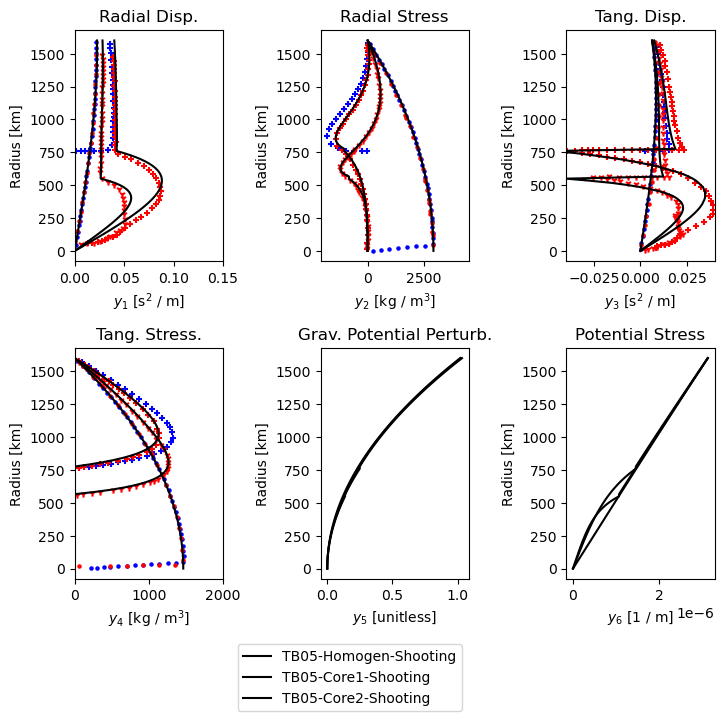

In [52]:
# Setup 3 models based on the three layer structures used in Tobie 2005
models = {'TB05-Homogen': (None, 3500.),
          'TB05-Core1': (5150, 3300.),
          'TB05-Core2': (8000, 3300.)}
model_radii = list()
model_names = list()
model_results = list()
model_colors = list()

for model_name, (core_density, mantle_density) in models.items():

    print(f'\n\nWorking on model {model_name}.\n------------------')
    t0 = time.time()

    # Determine the radius structure based on the density
    if core_density is None:
        R_core = None
    else:
        R_core = ((bulk_density - mantle_density) / (core_density - mantle_density))**(1 / 3) * R_planet

    # Set the density for each layer
    density_array = mantle_density * np.ones_like(radius_array)
    mantle_radii = np.ones_like(radius_array, dtype=np.bool_)
    core_radii = None
    if R_core is not None:
        core_radii = radius_array <= R_core
        mantle_radii = radius_array > R_core
        density_array[core_radii] = core_density

    # Calculate masses, mass below, gravities
    mass_array = volume_array * density_array

    masses_below = np.zeros_like(radius_array)
    masses_below[0] = mass_array[0]
    masses_below[1:] = np.asarray([sum(mass_array[0:i+1]) for i in range(1, N)])

    gravity_array = G * masses_below / radius_array**2

    # Calculate rheological properties
    viscosity_array = viscosity_mantle * np.ones_like(radius_array)
    if R_core is not None:
        viscosity_array[core_radii] = viscosity_core

    shear_array = shear_mantle * np.ones_like(radius_array)
    bulk_array = bulk_mantle * np.ones_like(radius_array)
    if R_core is not None:
        shear_array[core_radii] = shear_core
        bulk_array[core_radii] = bulk_core

    # Use the Maxwell rheology
    rheology_inst = Maxwell()
    complex_shear_array = np.zeros(shear_array.size, dtype=np.complex128)
    rheology_inst.vectorize_modulus_viscosity(orbital_freq, shear_array, viscosity_array, complex_shear_array)

    if show_propagation_matrix_technique:
        print('Solving with propagation matrix...')
        if R_core is None:
            # Find the fundamental matrix; skip the innermost shell as that will be a boundary condition.
            Y, Y_inv, derivative_mtx = \
                fundamental_matrix_orderl2(radius_array, complex_shear_array, density_array, gravity_array)
            radius_used = radius_array
        else:
            Y, Y_inv, derivative_mtx = \
                fundamental_matrix_orderl2(radius_array[radius_array > R_core],
                                           complex_shear_array[radius_array > R_core],
                                           density_array[radius_array > R_core],
                                           gravity_array[radius_array > R_core])
            radius_used = radius_array[radius_array > R_core]

        # Propagate the tidal solution through the world's shells
        central_boundary_condition = np.zeros((6, 3), dtype=np.complex128)
        # Roberts & Nimmo (2008): Liquid innermost zone.
        central_boundary_condition[0, 0] = 0.05
        central_boundary_condition[1, 1] = 0.01
        central_boundary_condition[5, 2] = 1.

        tidal_y_prop = \
            matrix_propagate(Y, Y_inv, derivative_mtx, central_boundary_condition, R_planet, order_l=2)

        model_radii.append(radius_used)
        model_names.append(model_name + '-PropMtx')
        model_results.append(tidal_y_prop)
        model_colors.append('orange')

    # Solve for radial functions using a numerical shooting method
    if show_shooting_method_technique:
        print('Solving with shooting method...')
        if R_core is None:
            # Use homogeneous method
            radial_solution = \
                radial_solver(
                    radius_array,
                    density_array,
                    gravity_array,
                    bulk_array,
                    complex_shear_array,
                    orbital_freq,
                    planet_bulk_density,
                    layer_types=('solid',),
                    is_static_by_layer=(use_static_mantle,),
                    is_incompressible_by_layer=(use_real_incompressible_limit,),
                    upper_radius_by_layer=(R_planet,),
                    degree_l=2,
                    solve_for=('tidal',),
                    use_kamata=use_kamata_starting_values,
                    integration_method=integration_method,
                    integration_rtol=r_tol,
                    integration_atol=a_tol,
                    scale_rtols_by_layer_type=False,
                    max_num_steps=5_000_000,
                    max_ram_MB=2_000,
                    nondimensionalize=nondimensionalize_during_integration
                    )
            if not radial_solution.success:
                raise AssertionError(radial_solution.message)
            tidal_y_shoot = np.copy(radial_solution.result)
        else:
            # Use liquid-solid method
            radial_solution = \
                radial_solver(
                    radius_array,
                    density_array,
                    gravity_array,
                    bulk_array,
                    complex_shear_array,
                    orbital_freq,
                    planet_bulk_density,
                    layer_types=('liquid', 'solid'),
                    is_static_by_layer=(use_static_liquid_core, use_static_mantle),
                    is_incompressible_by_layer=(use_real_incompressible_limit, use_real_incompressible_limit),
                    upper_radius_by_layer=(R_core, R_planet),
                    degree_l=2,
                    solve_for=('tidal',),
                    use_kamata=use_kamata_starting_values,
                    integration_method=integration_method,
                    integration_rtol=r_tol,
                    integration_atol=a_tol,
                    scale_rtols_by_layer_type=False,
                    max_num_steps=5_000_000,
                    max_ram_MB=2_000,
                    nondimensionalize=nondimensionalize_during_integration
                    )
            if not radial_solution.success:
                raise AssertionError(radial_solution.message)
            tidal_y_shoot = np.copy(radial_solution.result)

        model_radii.append(radius_array)
        model_names.append(model_name + '-Shooting')
        model_results.append(tidal_y_shoot)
        model_colors.append('k')

    print(f'\n\nModel {model_name} Completed!. Taking {time.time() - t0:0.3f}s\n------------------')

_ = yplot(model_results, model_radii, labels=model_names, colors=model_colors,
      use_tobie_limits=True, plot_tobie=plot_tobie, plot_roberts=plot_roberts)


# BVP Approach
# from scipy.integrate import solve_bvp
# surf_condition = (5. / R_planet)
# def bc_residual(ya, yb):
#     return (ya[0], yb[1], ya[2], yb[3], ya[4], yb[5] - surf_condition)
#
# solution_ys = list()
# solution_rs = list()
# for sn in range(3):
#
#     initial_guess = initial_solutions[sn]
#     solution = solve_bvp(deriv_sol, bc_residual, radius_array[radius_array > R_core], initial_guess, tol=1e-3, verbose=2)
#
#     print(f'Solving Solution {sn}')
#     #     solution = solve_ivp(deriv_sol, span, initial_solutions[sn][:, 0])
#     if solution.status == 0:
#         print(f'Solution {sn} solved.')
#         solution_rs.append(solution.x)
#         solution_ys.append(solution.y)
#     else
#         print(solution.message)
#
# solution_ys.append(tidal_y_ivp)
# solution_rs.append(tidal_y_ivp_r)
#
# if len(solution_ys) != 0:
#     yplot(solution_ys, solution_rs)